# CSE 5524 HW 3 Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [526]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color


### Read and resize input RGB image

(641, 401)


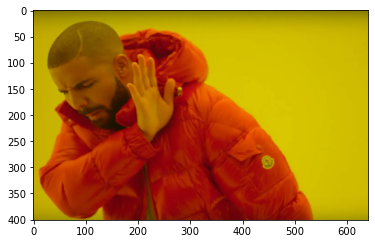

In [481]:
image1 = Image.open('Q1_Input Image.png') #Creates image object of original input RGB image

# R = (Mr * 2^N) + 1
# C = (Mc * 2^N) + 1

# Here, N=3, and by taking Mr=80 & Mc=50, we get R=641 & C=401

inputImageResized = image1.resize((641, 401)) #Resizes original input RGB image
inputImageResized.save('Input RGB Image Resized.png') #Saves resized input RGB image

plt.imshow(inputImageResized) #Displays resized input RGB image
print(inputImageResized.size) #Prints size of resized input RGB image


### Convert resized RGB image to single channel grayscale image

(401, 641)


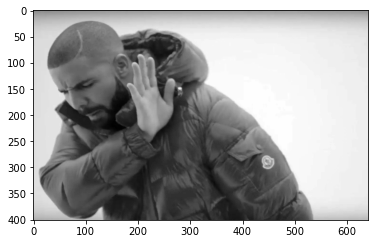

In [482]:
image2 = cv.imread('Input RGB Image Resized.png') #Creates image object of resized input RGB image
inputImageResizedGray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY) #Convert resized input RGB image to resized single channel grayscale image
plt.imshow(inputImageResizedGray, cmap='gray') #Displays resized grayscale image

# print(image2.shape) #Prints shape of resized RGB image
print(inputImageResizedGray.shape) #Print shape of resized single channel grayscale image



### Create two separable Gaussian mask kernels: Wm and Wn

In [483]:
#G(m,n) = w(m) * w(n) where w = [0.25-0.5*a 0.25 a 0.25 0.25-0.5a]
#Here a=0.4, hence w = [0.05 0.25 0.4 0.25 0.05]

wm = np.array([[0.05,0.25,0.4,0.25,0.05]])
wn = wm.transpose()

print(wm)
print(wn)

[[0.05 0.25 0.4  0.25 0.05]]
[[0.05]
 [0.25]
 [0.4 ]
 [0.25]
 [0.05]]


### Create 1D Gaussian Blur function across columns using Wm kernel

In [487]:
def gaussianBlurColumn(inputImageResizedGray):

    a,b = inputImageResizedGray.shape #Gets number of rows (or height) (a) and number of columns (or width) (b)
    wmImage = np.zeros((a,b))        #Creates a vector with 'a' rows and 'b' columns with all values zero
    i=0
    j=0
    while(i<a):
        while(j<b-4):
            wmImage[i][j+2] = wm[0][0]*inputImageResizedGray[i][j] + wm[0][1]*inputImageResizedGray[i][j+1] + wm[0][2]*inputImageResizedGray[i][j+2] + wm[0][3]*inputImageResizedGray[i][j+3] + wm[0][4]*inputImageResizedGray[i][j+4]
            j+=1
        i+=1
        j=0
    
    return wmImage    



### 1D Gaussian Blur across row using Wn kernel for Level 1

In [489]:
def gaussianBlurRow(wmImage):

    c,d = wmImage.shape #Gets number of rows (or height) (x) and number of columns (or width) (y)
    wnImage = np.zeros((c,d))
    i=0
    j=0
    while(j<d):
        while(i<c-4):
            wnImage[i+2][j] = wn[0][0]*wmImage[i][j] + wn[1][0]*wmImage[i+1][j] + wn[2][0]*wmImage[i+2][j] + wn[3][0]*wmImage[i+3][j] + wn[4][0]*wmImage[i+4][j]
            i+=1
        j+=1
        i=0

    return wnImage



### Create interpolation function

In [490]:
def interpolation(input_img):

    a,b = input_img.shape                         #Gives rows (height) (a) and columns (width) (b) of input image
    output_img = np.zeros((2*a - 1,2*b - 1))        #Creates blank image (=0) of dimensions (2a-1,2b-1)

    i=0
    j=0

    while(i< (2*a - 1)):
        while(j< (2*b - 1)):
            if(j%2==0):
                output_img[i][j] = input_img[math.floor(i/2)][math.floor(j/2)]
            else:
                output_img[i][j] = (input_img[math.floor(i/2)][math.floor(j/2)] + input_img[math.floor(i/2)][math.floor(j/2)+1]) / 2
            j+=1
        i+=1
        j=0
    
    i=1
    while(i< (2*a - 1)):
        output_img[i] = (output_img[i-1] + output_img[i+1]) / 2
        i+=2
    
    return output_img
    


### Perform gaussian blurring and downsampling to get Level 1

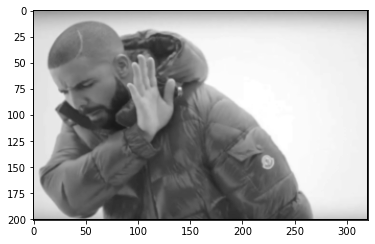

In [491]:
blurredColumn1 = gaussianBlurColumn(inputImageResizedGray)
blurredRow1 = gaussianBlurRow(blurredColumn1)
gaussianPyramidLevel1 = blurredRow1[0::2,0::2]
plt.imshow(gaussianPyramidLevel1, cmap='gray')

### Perform gaussian blurring and downsampling to get Level 2

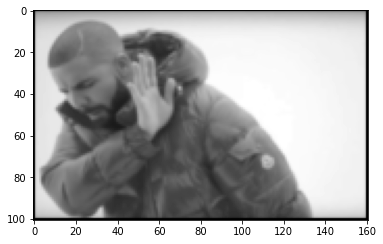

In [492]:
blurredColumn2 = gaussianBlurColumn(gaussianPyramidLevel1)
blurredRow2 = gaussianBlurRow(blurredColumn2)
gaussianPyramidLevel2 = blurredRow2[0::2,0::2]
plt.imshow(gaussianPyramidLevel2, cmap='gray')

### Perform gaussian blurring and downsampling to get Level 3

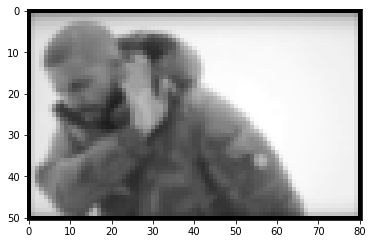

In [493]:
blurredColumn3 = gaussianBlurColumn(gaussianPyramidLevel2)
blurredRow3 = gaussianBlurRow(blurredColumn3)
gaussianPyramidLevel3 = blurredRow3[0::2,0::2]
plt.imshow(gaussianPyramidLevel3, cmap='gray')

### Get interpolation estimates for N=2, N=1, and N=0 levels

In [494]:
#Following section is to get interpolation estimates for N=2 from Gaussian pyramid at N=3

interpolationLevel2 = interpolation(gaussianPyramidLevel3)
#plt.imshow(interpolationLevel2, cmap='gray')

#Following section is to get interpolation estimates for N=1 from Gaussian pyramid at N=2

interpolationLevel1 = interpolation(gaussianPyramidLevel2)
#plt.imshow(interpolationLevel1, cmap='gray')

#Following section is to get interpolation estimates for N=0 from Gaussian pyramid at N=1

interpolationLevel0 = interpolation(gaussianPyramidLevel1)
#plt.imshow(interpolationLevel0, cmap='gray')

### Get Laplacian pyramid for N=3

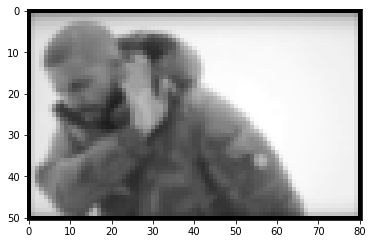

In [495]:
laplacianPyramidLevel3 = gaussianPyramidLevel3
plt.imshow(laplacianPyramidLevel3, cmap='gray')

### Get Laplacian pyramid for N=2

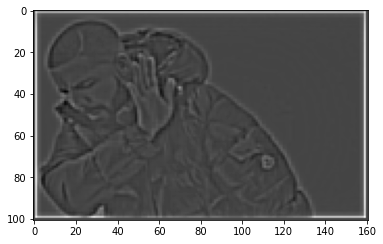

In [496]:
laplacianPyramidLevel2 = gaussianPyramidLevel2 - interpolationLevel2
plt.imshow(laplacianPyramidLevel2, cmap='gray')

### Get Laplacian pyramid for N=1

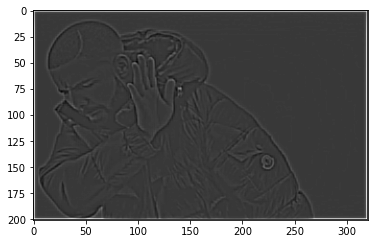

In [497]:
laplacianPyramidLevel1 = gaussianPyramidLevel1 - interpolationLevel1
plt.imshow(laplacianPyramidLevel1, cmap='gray')

### Get Laplacian pyramid for N=0

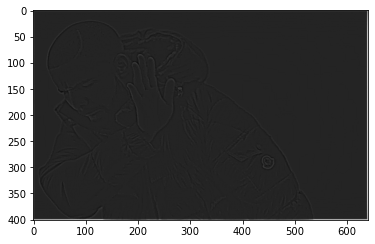

In [498]:
laplacianPyramidLevel0 = inputImageResizedGray - interpolationLevel0
plt.imshow(laplacianPyramidLevel0, cmap='gray')

### Image reconstruction for N=3

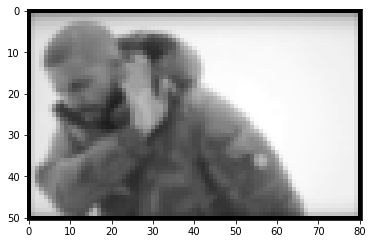

In [499]:
reconstructedImageLevel3 = laplacianPyramidLevel3
plt.imshow(reconstructedImageLevel3, cmap='gray')

### Image reconstruction for N=2

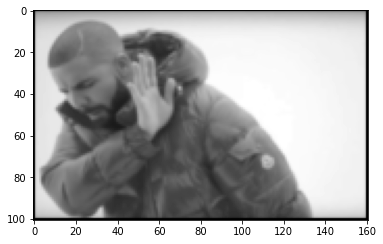

In [500]:
reconstructedImageLevel2 = laplacianPyramidLevel2 + interpolationLevel2
plt.imshow(reconstructedImageLevel2, cmap='gray')

### Image reconstruction for N=1

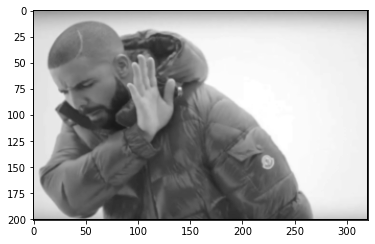

In [501]:
reconstructedImageLevel1 = laplacianPyramidLevel1 + interpolationLevel1
plt.imshow(reconstructedImageLevel1, cmap='gray')

### Image reconstruction for N=0

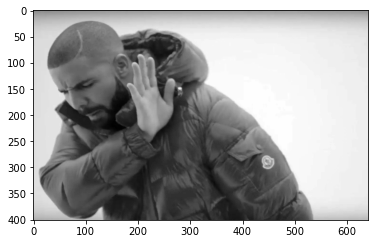

In [248]:
reconstructedImageLevel0 = laplacianPyramidLevel0 + interpolationLevel0
plt.imshow(reconstructedImageLevel0, cmap='gray')

##### Discussion

Original images require a lot of computation to send/receive. With the use of a Laplacia pyramid, we can send and resconstruct the original image with much less time and more efficiency.

## Question 2

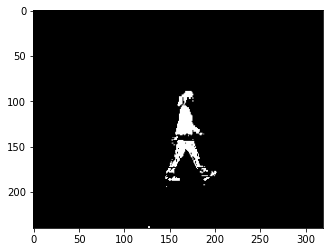

In [507]:
background000 = cv.imread('bg000.bmp')                             #Reads input background image
background000 = np.asarray(background000,dtype=np.float64)         #Converts input background image to type double
foreground = cv.imread('walk.bmp')                                 #Reads foreground image
foreground = np.asarray(foreground,dtype=np.float64)               #Converts foreground image to type double

a,b,c = background000.shape         #Gets rows(a), columns(b), and channels(c) of input image

outputImage = np.zeros((a,b,c))    #Creates a zero image with same dimensions as input image

i=0
j=0
k=0
T=80           #Set threshhold value

while(k<c):
    while(i<a):
        while(j<b):
            if(abs(background000[i][j][k] - foreground[i][j][k]) > T):
                outputImage[i][j][k] = 1
            j+=1
        i+=1
        j=0
    k+=1
    i=0
    j=0
    
plt.imshow(outputImage,cmap='gray')


##### Discussion

For lower threshhold values, we see that along with foreground, more than required sections of background are also retained. And for higher values of threshhold, less than required sections of foreground are retained. Hence, values around T=60 gives an acceptable background subtraction for type 1

## Question 3

In [509]:
#Following section reads multiple background images

backgroundImages = [cv.imread(file) for file in glob.glob("bg images/*.bmp")]

a,b,c = backgroundImages[0].shape    #Gets rows, columns, and channels in background images
i=0     #For rows
j=0     #For columns
k=0     #For channel
l=0     #To access images for average
m=0     #To access images for variance
add=0
square=0
pixelAverage = np.zeros((a,b,c))
pixelAverage = np.asarray(pixelAverage,dtype=np.float64)
pixelVariance = np.zeros((a,b,c))
pixelVariance = np.asarray(pixelVariance,dtype=np.float64)

#Following section generates matrix with average values of pixels in time domain (pixelAverage) and matrix with variance of pixels in time domain (pixelVariance)

for k in range(c):
    for i in range(a):
        for j in range(b):
            
            for l in range(30):
                add += backgroundImages[l][i][j][k]
            pixelAverage[i][j][k] = add/30
            add = 0
            
            for m in range(30):
                square += ((backgroundImages[m][i][j][k] - pixelAverage[i][j][k])**2)
            pixelVariance[i][j][k] = square/30
            square = 0


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_2393/1705601871.py:4: RuntimeWarning: divide by zero encountered in true_divide
  outputImage = ((foreground - pixelAverage)**2) / (pixelVariance) > T**2
/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_2393/1705601871.py:4: RuntimeWarning: invalid value encountered in true_divide
  outputImage = ((foreground - pixelAverage)**2) / (pixelVariance) > T**2


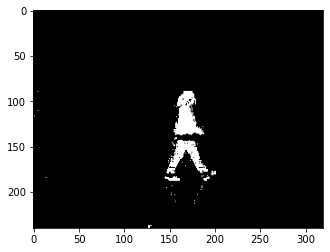

In [510]:
T=15     #Set threshhold value    

outputImage = np.zeros((a,b,c))
outputImage = ((foreground - pixelAverage)**2) / (pixelVariance) > T**2
outputImage = np.asarray(outputImage,dtype=np.float64)
plt.imshow(outputImage,cmap='gray')


###### Discussion

We see that a much more recognizable subtraction is done using this method. Also, the threshhold value required for this technique (15) is much lower than what was required in background subtraction 1 (60) to get acceptable output

## Question 4

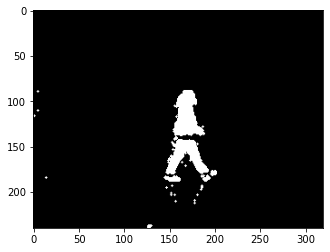

In [459]:
dilatedImage = morphology.dilation(outputImage)
plt.imshow(dilatedImage,cmap='gray')

###### Discussion

Dilation adds pixels to the boundary of object in an image. Here, we see that the object has more white pixels than the original binary image.

## Question 5

In [531]:
L,num = measure.label(dilatedImage,connectivity=2,return_num=True)
print('Number of regions is',num)



Number of regions is 18
